In [17]:
import xarray as xr
import datetime
from dateutil.relativedelta import relativedelta
import os

In [60]:
# function for adjusting time info 
def adjust_monthly_datetime_info(ds):

    ds_adj = ds.copy(deep=True)
    # adjust datetime time information
    start_time_str = ds_adj["time"].attrs["units"].replace("months since ", "")
    start_time_obj = datetime.datetime.strptime(start_time_str, '%Y-%m-%d %H:%M:%S')
    
    # In the following, we add the relative timedelta in months to our starting time. These will be stored in ds['time'].
    timesteps = [start_time_obj + relativedelta(months=im) for im in ds_adj['time']]
    ds_adj['time'] = timesteps

    return ds_adj

In [122]:
var = 'TminM' # data variable to preprocess

data_list = os.listdir(fr'../data/{var}/{var}/')[1:] # list of data files in the ZIP file, excluding the year 2023 folder
data_list_remaining = os.listdir(fr'../data/{var}/{var}/2023') # list of date files in the ZIP file for the year 2023

In [123]:
data_list[0]

'TminM_ch01r.swiss.lv95_197101010000_197112010000.nc'

In [124]:
ds = xr.open_mfdataset([fr'../data/{var}/{var}/' + data_name for data_name in data_list], decode_times=False) # open multi-file data, excluding 2023

In [125]:
ds_adjusted = adjust_monthly_datetime_info(ds) # adjust time info (from 'months since' to real dates)

In [126]:
ds_adjusted

<xarray.Dataset>
Dimensions:                 (time: 624, E: 370, N: 240)
Coordinates:
  * E                       (E) float64 2.474e+06 2.476e+06 ... 2.844e+06
  * N                       (N) float64 1.064e+06 1.066e+06 ... 1.304e+06
  * time                    (time) datetime64[ns] 1971-01-01 ... 2022-12-01
    lon                     (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>
    lat                     (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>
Data variables:
    swiss_lv95_coordinates  (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TminM                   (time, N, E) float32 dask.array<chunksize=(12, 240, 370), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    institution:  Federal Office of Meteorology and Climatology MeteoSwiss
    References:   Frei C., 2014: Interpolation of temperatures in a mountaino...

In [127]:
ds_remaining = xr.open_mfdataset([fr'../data/{var}/{var}/2023/' + data_name for data_name in data_list_remaining], decode_times=False) # open data for year 2023

In [128]:
ds_remaining_adjusted = adjust_monthly_datetime_info(ds_remaining) # adjust the time info for year 2023

In [129]:
ds_remaining_adjusted

<xarray.Dataset>
Dimensions:                 (time: 9, E: 370, N: 240)
Coordinates:
  * E                       (E) float64 2.474e+06 2.476e+06 ... 2.844e+06
  * N                       (N) float64 1.064e+06 1.066e+06 ... 1.304e+06
  * time                    (time) datetime64[ns] 2023-01-01 ... 2023-09-01
    lon                     (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>
    lat                     (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>
Data variables:
    swiss_lv95_coordinates  (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
    TminM                   (time, N, E) float32 dask.array<chunksize=(1, 240, 370), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    institution:  Federal Office of Meteorology and Climatology MeteoSwiss
    References:   Frei C., 2014: Interpolation of temperatures in a mountaino...

In [130]:
ds_merged = xr.merge([ds_adjusted, ds_remaining_adjusted]) # merge the two data (data excluding 2023 and data including 2023)

In [131]:
ds_merged

<xarray.Dataset>
Dimensions:                 (E: 370, N: 240, time: 633)
Coordinates:
  * E                       (E) float64 2.474e+06 2.476e+06 ... 2.844e+06
  * N                       (N) float64 1.064e+06 1.066e+06 ... 1.304e+06
  * time                    (time) datetime64[ns] 1971-01-01 ... 2023-09-01
    lon                     (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>
    lat                     (N, E) float32 dask.array<chunksize=(240, 370), meta=np.ndarray>
Data variables:
    swiss_lv95_coordinates  (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    TminM                   (time, N, E) float32 dask.array<chunksize=(625, 240, 370), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    institution:  Federal Office of Meteorology and Climatology MeteoSwiss
    References:   Frei C., 2014: Interpolation of temperatures in a mountaino...

In [132]:
# get start and end years of the data for path name purposes
start_year = int(ds_merged['time'][0].dt.year)
end_year = int(ds_merged['time'][-1].dt.year)

In [133]:
ds_merged.to_netcdf(fr'../data/adjusted/{var}_{start_year}_{end_year}_monthly.nc') # save data

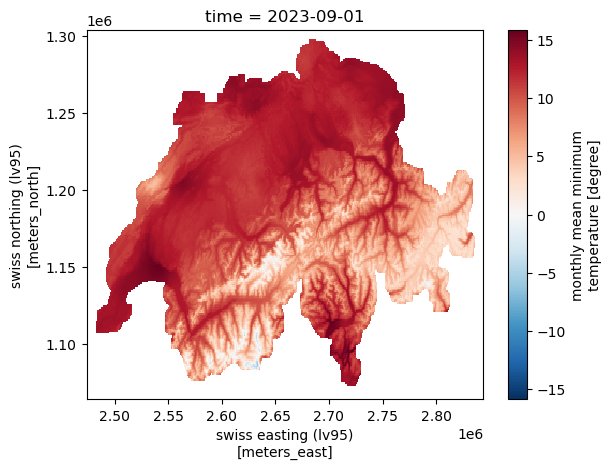

In [134]:
xr.open_dataset(fr'../data/adjusted/{var}_{start_year}_{end_year}_monthly.nc')[var].isel(time=-1).plot() # open the saved data